# **House Prices - Advanced Regression Techniques**
January 5, 2025<br>
Ying-Fang Liang<br>
<nav>
<a href=”https://www.linkedin.com/in/ying-fang-liang/">LinkedIn</a> |
<a href=”https://github.com/yingfangliang”>Github</a> | 
<a href="https://www.kaggle.com/lyflyflyf">Kaggle</a>
</nav>

***
## **Table of Content**<a id=top></a>
0. **Setup**
    1. [Library, Self-Defined Functions, and Data](#0a)
2. **Data Exploration**
    1. [Data types and distributions](#1a)
    2. [Correlations](#1b)
3. **Data Preparation**
    1. [Missing values](#2a)
    2. [Outliers](#2b)
    3. [Categorical attributes: Encoding](#2c)
    4. [Numerical attributes: Scaling](#2d)
    5. [Feature engineering](#2e)
    6. [Feature selection](#2f)
4. **Model Training with Cross Validation**
    1. [Linear regression](#3a)
    2. [Ridge regression](#3b)
    3. [Lasso regression](#3c)
    4. [Elastic net regression](#3d)
    5. [Stocastic gradient descent regression](#3e)
    6. [Gradient boosting regression](#3f)
    7. [Random forest regression](#3g)
    8. [XGBoost regression](#3h)
5. **Model Fine-Tuning**
    1. [Grid search](#4a)
    2. [Randomized search](#4b)
6. **Model Evaluation and Competition Submission**
    1. [Result comparison](#5a)
    2. [Test set preparation and check](#5b)

```python
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
```

## 0. **Setup**
### A. <a id=0a>Libraries, Self-Defined Functions, and Data</a>
[➥ Back to top](#top) 

#### Libraries

In [1]:
# For data processing and manipulation
import pandas as pd
import numpy as np

# For making df.info() a dataframe
import io

# For plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots 

# For modelling
from sklearn.ensemble import IsolationForest, ExtraTreesClassifier
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel

# Set pandas display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Set matplotlib parameters
plt.style.use("ggplot")
plt.rcParams['axes.facecolor'] = "WhiteSmoke"

#### Functions

In [2]:
# For getting info and describe details into the same dataframe
def getInfoAndDescribe(df):
    buf = io.StringIO()
    df.info(buf=buf)
    s = buf.getvalue()
    lines = [[line.split()[1], df.shape[0]-int(line.split()[2]), line.split()[4]] for line in s.splitlines()[5:-2]]

    # Combine .info() and .describe()
    df_info = pd.DataFrame(lines, columns=["index", "Null Count", "Data Type"]).set_index("index")
    df_info["Null Percentage"] = (df_info["Null Count"]/df.shape[0]).apply(lambda x: "{:.1%}".format(x))
    df_info = df_info[["Data Type", "Null Count", "Null Percentage"]]
    df_describe = df_train.describe().T.drop(columns="count")
    df_all = df_info.join(df_describe, how="left").reset_index().rename(columns={"index":"Attribute"}).replace(np.nan,"")

    # Get unique counts for categorical attributes
    nunique_list = []
    for _, row in df_all.iterrows():
        if row["Data Type"] == "object":
            nunique_list.append(df[row["Attribute"]].nunique())
        else:
            nunique_list.append("")
    df_all["Unique Count"] = nunique_list

    # Capitalize each word in column names cus I'm OCD
    df_all.columns = [col.title() for col in df_all.columns]
    return df_all

#### Data
Modify **MSSubClass** and **Id** data type to `str` as one is using number as the category name and the other is the index.

In [3]:
# Data
df_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
df_train["MSSubClass"] = df_train["MSSubClass"].astype("str")
df_train["Id"] = df_train["Id"].astype("str")

for col in ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", 
            "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]:
    df_train[col].fillna("NA", inplace=True)
for col in ["MasVnrType"]:
    df_train[col].fillna("None", inplace=True)

<ipython-input-3-8927ddbd3faa>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[col].fillna("NA", inplace=True)
<ipython-input-3-8927ddbd3faa>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.met

In [4]:
display(df_train.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000


## 1. **Data Exploration**
### A. <a id=1a>Data types and distributions</a>
[➥ Back to top](#top) 

#### Glimpse
Using `info()` and `describe()` to check data types, null counts, stats (for numerical attributes), and unique counts (for categorical atrributes).

In [5]:
df_info = getInfoAndDescribe(df_train)
display(df_info)

,Attribute,Data Type,Null Count,Null Percentage,Mean,Std,Min,25%,50%,75%,Max,Unique Count
0,Id,object,0,0.0%,,,,,,,,1460
1,MSSubClass,object,0,0.0%,,,,,,,,15
2,MSZoning,object,0,0.0%,,,,,,,,5
3,LotFrontage,float64,259,17.7%,70.049958,24.284752,21.0,59.0,69.0,80.0,313.0,
4,LotArea,int64,0,0.0%,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.5,215245.0,
5,Street,object,0,0.0%,,,,,,,,2
6,Alley,object,0,0.0%,,,,,,,,3
7,LotShape,object,0,0.0%,,,,,,,,4
8,LandContour,object,0,0.0%,,,,,,,,4
9,Utilities,object,0,0.0%,,,,,,,,2


> ⚠️&nbsp;&nbsp;<font color="red">**Notes**<br>Ideas for later on feature selection</font><br>
> - <font color="MediumSlateBlue">**High cardinality:**</font><br>
**MSSubClass, Neighborhood**<br>
<u>Reduce dimensions</u> maybe by grouping (some categories might share similar impact on the target)?<br>
<u>Disgard</u> some variables if they're not significant to the target.
> - <font color="MediumSlateBlue">**A LOT OF missing values:**</font><br>
**LotFrontage<font color="red">\*</font>**<br>
<u>Does NULL actually mean something?</u> Check if there's any distinction between null and non-null cases.<br>
<u>Disgard</u> some variables if they're not significant to the target.
> - <font color="MediumSlateBlue">**A FEW missing values:**</font><br>
**MasVnrArea<font color="red">\*</font>, Electrical, GarageYrBlt<font color="red">\*</font>**<br>
<u>Does NULL actually mean something?</u> Check if there's any distinction between null and non-null cases.<br>
Fill in missing values with mean, median, or most common value?<br><br>
> <font color="red">**\***</font> Numercial attributes

#### Target Distribution

In [6]:
sd = df_train.SalePrice.std()
m = df_train.SalePrice.mean()

fig = px.histogram(df_train, x="SalePrice", marginal="rug", color_discrete_sequence=["DarkSeaGreen"])

fig.add_vline(x=m - sd, line_width=2, line_dash="longdash", line_color="green")
fig.add_vline(x=m + sd, line_width=2, line_dash="longdash", line_color="green")
fig.add_vline(x=m - 2*sd, line_width=2, line_dash="dash", line_color="green")
fig.add_vline(x=m + 2*sd, line_width=2, line_dash="dash", line_color="green")
fig.add_vline(x=max(m - 3*sd, 0), line_width=2, line_dash="dot", line_color="green")
fig.add_vline(x=m + 3*sd, line_width=2, line_dash="dot", line_color="green")

fig.add_vrect(x0=m + 3*sd, x1=df_train.SalePrice.max(), line_width=0, fillcolor="red", opacity=0.1)

fig.add_annotation(x=m-sd, y=1.05, yref="paper", text="𝜇-1σ", showarrow=False)
fig.add_annotation(x=m+sd, y=1.05, yref="paper", text="𝜇+1σ", showarrow=False)
fig.add_annotation(x=m-2*sd, y=1.05, yref="paper", text="𝜇-2σ", showarrow=False)
fig.add_annotation(x=m+2*sd, y=1.05, yref="paper", text="𝜇+2σ", showarrow=False)
fig.add_annotation(x=m-3*sd, y=1.05, yref="paper", text="𝜇-3σ", showarrow=False)
fig.add_annotation(x=m+3*sd, y=1.05, yref="paper", text="𝜇+3σ", showarrow=False)

fig.update_layout(
    title="<b>SalePrice</b> Distribution",
    title_x=0.5, 
    plot_bgcolor="WhiteSmoke"
)

fig.show()

print("Observations with SalePrices that are more than 3σ away from the average:", 
      df_train[df_train.SalePrice > m+3*sd].shape[0] + df_train[df_train.SalePrice < m-3*sd].shape[0],
      "({:.2f}%)".format(100*(df_train[df_train.SalePrice > m+3*sd].shape[0] + df_train[df_train.SalePrice < m-3*sd].shape[0])/df_train.shape[0]),
      end="\n\n"
     )

Observations with SalePrices that are more than 3σ away from the average: 22 (1.51%)



In [7]:
df_train["SalePrice_log"] = np.log(df_train.SalePrice)

sd = df_train.SalePrice_log.std()
m = df_train.SalePrice_log.mean()
fig = px.histogram(df_train, x="SalePrice_log", marginal="rug", color_discrete_sequence=["DarkSeaGreen"])

fig.add_vline(x=m-sd, line_width=2, line_dash="longdash", line_color="green")
fig.add_vline(x=m+sd, line_width=2, line_dash="longdash", line_color="green")
fig.add_vline(x=m-2*sd, line_width=2, line_dash="dash", line_color="green")
fig.add_vline(x=m+2*sd, line_width=2, line_dash="dash", line_color="green")
fig.add_vline(x=max(m-3*sd, 0), line_width=2, line_dash="dot", line_color="green")
fig.add_vline(x=m+3*sd, line_width=2, line_dash="dot", line_color="green")

fig.add_vrect(x0=df_train.SalePrice_log.min(), x1=m - 3*sd, line_width=0, fillcolor="red", opacity=0.1)
fig.add_vrect(x0=m+3*sd, x1=df_train.SalePrice_log.max(), line_width=0, fillcolor="red", opacity=0.1)

fig.add_annotation(x=m-sd, y=1.05, yref="paper", text="𝜇-1σ", showarrow=False)
fig.add_annotation(x=m+sd, y=1.05, yref="paper", text="𝜇+1σ", showarrow=False)
fig.add_annotation(x=m-2*sd, y=1.05, yref="paper", text="𝜇-2σ", showarrow=False)
fig.add_annotation(x=m+2*sd, y=1.05, yref="paper", text="𝜇+2σ", showarrow=False)
fig.add_annotation(x=m-3*sd, y=1.05, yref="paper", text="𝜇-3σ", showarrow=False)
fig.add_annotation(x=m+3*sd, y=1.05, yref="paper", text="𝜇+3σ", showarrow=False)

fig.update_layout(
    title="log(<b>SalePrice</b>) Distribution",
    title_x=0.5, 
    plot_bgcolor="WhiteSmoke"
)

fig.show()

print("Observations with log(SalePrices) that are more than 3σ away from the average:", 
      df_train[df_train.SalePrice_log > m+3*sd].shape[0] + df_train[df_train.SalePrice_log < m-3*sd].shape[0],
      "({:.2f}%)".format(100*(df_train[df_train.SalePrice_log > m+3*sd].shape[0] + df_train[df_train.SalePrice_log < m-3*sd].shape[0])/df_train.shape[0]),
      end="\n\n"
     )

df_train.drop(columns="SalePrice_log", inplace=True)

Observations with log(SalePrices) that are more than 3σ away from the average: 12 (0.82%)



> ⚠️&nbsp;&nbsp;<font color="red">**Note**<br>Ideas for later on model training</font><br>
> - Based on the algorithms we will use late:
>    - Some algorithms perform better when the target has a normal distribution, for example: linear regression.
>    - Tree-based models do not require the target to have a normal distribution.
> - It might be easier to detect outliers if the target is a normal distribution.

#### Attribute Types

In [8]:
attr_num = df_info[df_info["Data Type"] != "object"]["Attribute"][:-1].tolist() # Remove[-1] (SalePrice)
attr_cat = df_info[df_info["Data Type"] == "object"]["Attribute"][1:].tolist() # Remove[0] (Id)
 
display(pd.DataFrame(attr_num, columns=["Numerical attributes ({})".format(len(attr_num))]))
display(pd.DataFrame(attr_cat, columns=["Categorical attributes ({})".format(len(attr_cat))]))

,Numerical attributes (35)
0,LotFrontage
1,LotArea
2,OverallQual
3,OverallCond
4,YearBuilt
5,YearRemodAdd
6,MasVnrArea
7,BsmtFinSF1
8,BsmtFinSF2
9,BsmtUnfSF


,Categorical attributes (44)
0,MSSubClass
1,MSZoning
2,Street
3,Alley
4,LotShape
5,LandContour
6,Utilities
7,LotConfig
8,LandSlope
9,Neighborhood


#### Numerical attributes
Quick distribution check using `df.hist()` for all numerical attributes

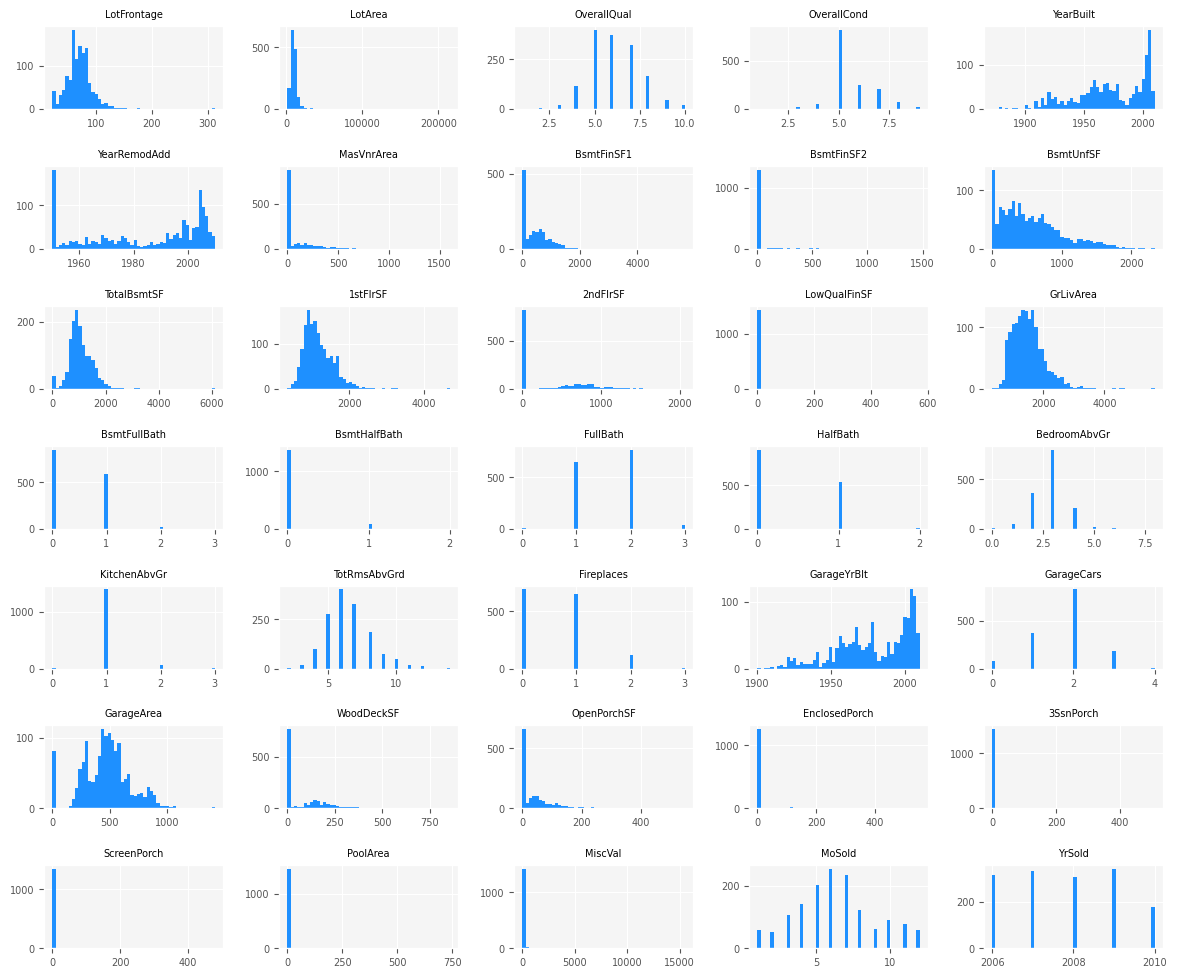

In [9]:
fig = df_train[attr_num].hist(bins=50, figsize=(12,10), layout=(7,5), xlabelsize=7, ylabelsize=7, color="DodgerBlue")
[x.title.set_size(7) for x in fig.ravel()]

plt.tight_layout(pad=1.5)
plt.show()

Close-in check for certain attributes' distributions

In [10]:
fig = go.Figure()

for i, attr in enumerate(attr_num):
    fig.add_trace(go.Histogram(
                    name=attr,
                    x=df_train[attr], 
                    #marginal="box", 
                    marker=dict(color="DodgerBlue"), 
                    #nbins=60,
                    visible=False
                    )
                )

button_list = []
for i, attr in enumerate(attr_num):
    button_list.append(dict(
                        label=attr, 
                        method="update", 
                        args=[
                            {"visible":[False]*i+[True]+[False]*(len(attr_num)-1-i)}, 
                            {"title.text": "<b>"+attr+"</b> Value Distribution"}]
                        )
                      )

fig.update_layout(
    height=400,  
    title="Numerical Attribute Value Distribution",
    title_x=0.5, 
    plot_bgcolor="WhiteSmoke",
    annotations=[
        dict(
            text="Choose a numerical attribute",
            xref="paper",
            x=0,
            yref="paper",
            y=1.42,
            align="left",
            showarrow=False,
            font=dict(color="grey", size=8)
        )
    ],
    updatemenus=[
        dict(
            active=-1, 
            buttons=list(button_list), 
            direction="down",
            showactive=True,
            xanchor="left",
            x=0,
            yanchor="top",
            y=1.35,
            font=dict(size=10),
            bordercolor="silver"
            )
        ]
    )

fig.show()

> ⚠️&nbsp;&nbsp;<font color="red">**Note**<br>Ideas for later on feature engineering</font><br>
> - **YearBuilt** and **YearRemodAdd** -> whether or not if a house is remodeled.
> - **YearBuilt** -> age of the house. Maybe using $cosine$ function?
> - **FullBath** and **HalfBath** -> the number of bath, like 2.5 bath. Same concept can be applied to other attributes.
> - Some variables like **EnclosedPorch** or **PoolArea** could be transformed to **<font color="MediumSlateBlue">Has</font>EnclosedPorch** and **<font color="MediumSlateBlue">Has</font>Pool**.
> - **MoSold** can be transformed to seasonality using $cosine$ function.
> - Most numerical variables are not very skewed. Thus, might not need apply any transformation, like $log$, to these variables.
> 

#### Categorical attributes

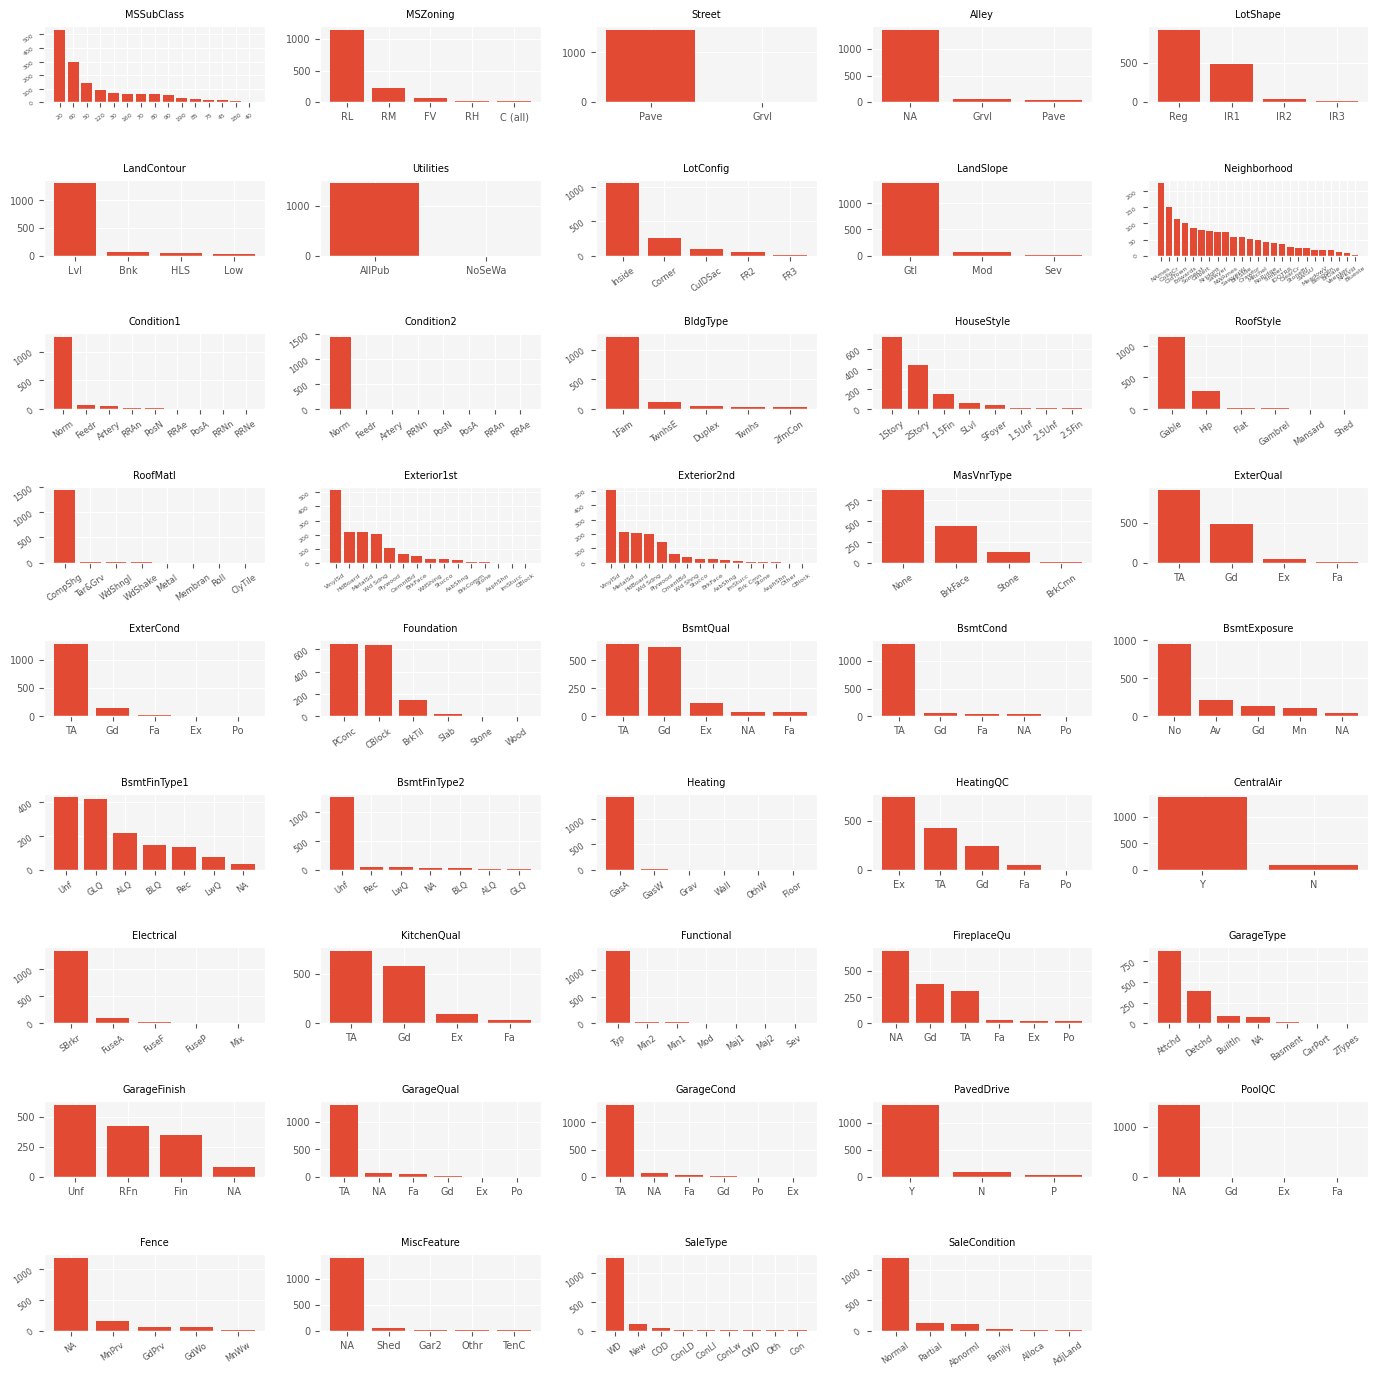

In [11]:
i = 0
fig, axes = plt.subplots(9, 5, figsize=(14, 14))
for row in range(9):
    for col in range(5):
        if i < len(attr_cat):
            axes[row, col].set_title(attr_cat[i], size=7)
            if len("".join(df_train[attr_cat[i]].value_counts().index)) < 20:
                labelsize = 7
                rotation = 0
            elif len(df_train[attr_cat[i]].value_counts().index) < 10:
                labelsize = 6
                rotation = 35
            else:
                labelsize = 4.5
                rotation = 35
            axes[row, col].tick_params(axis="both", which="major", labelsize=labelsize, rotation=rotation)
            axes[row, col].bar(df_train[attr_cat[i]].value_counts().index, 
                               df_train[attr_cat[i]].value_counts().values)
        else:
            axes[row, col].axis("off")
        i += 1

plt.tight_layout(pad=1.5)
plt.show()

In [12]:
fig = make_subplots(rows=2, cols=1, row_heights=[0.5, 0.3], shared_xaxes=True)

lvl_count = {}

for i, attr in enumerate(attr_cat):
    lvl_count[attr] = 0
    lvl_list = df_train[attr].unique().tolist() + ["Missing Value"] if df_train[attr].hasnans else df_train[attr].unique()
    for j, lvl in enumerate(lvl_list):
        if lvl != "Missing Value":
            fig.add_trace(go.Histogram(x=df_train[df_train[attr] == lvl]["SalePrice"], 
                                       name=lvl, 
                                       legendgroup=lvl, 
                                       marker={"color": px.colors.qualitative.Alphabet[j]},
                                       visible=True), row=1, col=1)
            fig.add_trace(go.Box(x=df_train[df_train[attr] == lvl]["SalePrice"], 
                                 name=lvl, 
                                 legendgroup=lvl, 
                                 marker={"color": px.colors.qualitative.Alphabet[j]},
                                 showlegend=False, 
                                 visible=True), row=2, col=1)
        else:
            fig.add_trace(go.Histogram(x=df_train[df_train[attr].isna()]["SalePrice"], 
                                       name=lvl, 
                                       legendgroup=lvl, 
                                       marker={"color": px.colors.qualitative.Alphabet[j]},
                                       visible=True), row=1, col=1)
            fig.add_trace(go.Box(x=df_train[df_train[attr].isna()]["SalePrice"], 
                                 name=lvl, 
                                 legendgroup=lvl, 
                                 marker={"color": px.colors.qualitative.Alphabet[j]},
                                 showlegend=False, 
                                 visible=True), row=2, col=1)
        lvl_count[attr] += 1


button_list = []
for attr in attr_cat:
    visible_list = []
    for a in attr_cat:
        option = True if a == attr else False
        visible_list.extend([option]*2*lvl_count[a])
    button_list.append(dict(
                        label=attr, 
                        method="update", 
                        args=[
                            {"visible":visible_list*2}, 
                            {"title.text": "SalePrice Distribution by <b>"+attr+"</b> Category"}]
                        )
                      )

fig.update_layout(
    height=800,  
    title="SalePrice Distribution by Categorical Attribute Value",
    title_x=0.5, 
    plot_bgcolor="WhiteSmoke",
    annotations=[
        dict(
            text="Choose a categorical attribute",
            xref="paper",
            x=0,
            yref="paper",
            y=1.15,
            align="left",
            showarrow=False,
            font=dict(color="grey", size=8)
        )
    ],
    updatemenus=[
        dict(
            active=-1, 
            buttons=list(button_list), 
            direction="down",
            showactive=True,
            xanchor="left",
            x=0,
            yanchor="top",
            y=1.12,
            font=dict(size=10),
            bordercolor="silver"
            )
        ]
    )

fig.update_traces(opacity=0.5)
fig.show()

In [13]:
count_list = df_train.Neighborhood.value_counts().values
min_list = []
q1_list = []
median_list = []
mean_list = []
q3_list = []
max_list = []

for n in df_train.Neighborhood.value_counts().index:
    min_list.append(df_train[df_train.Neighborhood == n]["SalePrice"].min())
    q1_list.append(df_train[df_train.Neighborhood == n]["SalePrice"].quantile(q=0.25))
    median_list.append(df_train[df_train.Neighborhood == n]["SalePrice"].median())
    mean_list.append(df_train[df_train.Neighborhood == n]["SalePrice"].mean())
    q3_list.append(df_train[df_train.Neighborhood == n]["SalePrice"].quantile(q=0.75))
    max_list.append(df_train[df_train.Neighborhood == n]["SalePrice"].max())

summary = pd.DataFrame({"Neighborhood": df_train.Neighborhood.value_counts().index,
                        "Count": count_list,
                        "Min": min_list,
                        "Q1": q1_list,
                        "Median": median_list,
                        "Mean": mean_list,
                        "Q3": q3_list,
                        "Max": max_list}).sort_values(by= "Median", ascending = False)
for col in ["Min", "Q1", "Median", "Mean", "Q3", "Max"]:
    summary[col] = summary[col].apply(lambda x: "{:d}k".format(int(x/1000)))

order_dict = {}
for i, n in enumerate(summary.Neighborhood):
    order_dict[n] = i

df_train["order"] = df_train["Neighborhood"].replace(order_dict)
fig = px.box(df_train.sort_values(by="order"), 
             x="Neighborhood", 
             y="SalePrice", 
             title="SalePrice Boxplot by <b>Neighborhood</b>")
fig.update_layout(title_x=0.5, plot_bgcolor="WhiteSmoke")
fig.show()

display(summary.set_index("Neighborhood").T)
df_train.drop(columns="order", inplace=True)

<ipython-input-13-5c1c34950801>:32: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Neighborhood,NridgHt,NoRidge,StoneBr,Timber,Somerst,Veenker,Crawfor,ClearCr,CollgCr,Blmngtn,NWAmes,Gilbert,SawyerW,Mitchel,NPkVill,NAmes,SWISU,Blueste,Sawyer,BrkSide,Edwards,OldTown,BrDale,IDOTRR,MeadowV
Count,77,41,25,38,86,11,51,28,150,17,73,79,59,49,9,225,25,2,74,58,100,113,16,37,17
Min,154k,190k,170k,137k,144k,162k,90k,130k,110k,159k,82k,141k,76k,84k,127k,87k,60k,124k,62k,39k,58k,37k,83k,34k,75k
Q1,253k,265k,213k,186k,177k,184k,159k,183k,152k,174k,165k,174k,145k,131k,140k,127k,128k,130k,127k,100k,101k,105k,91k,81k,83k
Median,315k,301k,278k,228k,225k,218k,200k,200k,197k,191k,182k,181k,179k,153k,146k,140k,139k,137k,135k,124k,121k,119k,106k,103k,88k
Mean,316k,335k,310k,242k,225k,238k,210k,212k,197k,194k,189k,192k,186k,156k,142k,145k,142k,137k,136k,124k,128k,128k,104k,100k,98k
Q3,374k,341k,377k,286k,252k,282k,239k,242k,225k,213k,205k,197k,222k,171k,148k,158k,160k,144k,149k,141k,145k,140k,118k,120k,115k
Max,611k,755k,556k,378k,423k,385k,392k,328k,424k,264k,299k,377k,320k,271k,155k,345k,200k,151k,190k,223k,320k,475k,125k,169k,151k


> ⚠️&nbsp;&nbsp;<font color="red">**Note**<br>Ideas for later on feature engineering</font><br>
> - **MSZoning**: *RL* and *RM* (Residential Low and Medium) are the majority. Yet *C (all)* has a relatively low SalePrice distribution compared to the others. Can Try to flag *C (all)* maybe.
> - **Street**: This attribute has only 2 levels. *Pave* is the majority compared to *Grvl*, yet we don't see a significant difference between the SalePrice distributions from these two levels. Consider to disgard this attribute?
> - **Alley**: Drop as most of observations has no value and NA observations don't show significant different SalePrice.
> - **LotShape**: No significant difference among levels, but could maybe try encode them to *regular* and *irregular* just to explore?
> - **Utilities**: MOSTLY *AllPub*, and SalePrices of the only few houses with *NoSeWa* lay within Q1 to Q3 of *AllPub*'s distribution. Consider to disgard this attribute.
> - **Neighborhood**: Consider to group them by SalePrice distributions.
> - **Condition1** & **Condition2**: Most of them have *Norm*, yet *RRNe* seems to have slightly higher distribution. Consider to check if each house has a *RRNe* in either of these two columns.
> - **HouseStyle**: Can be split into *2+ story* and *other*, including 1.x, split foyer, and split level.
> - **Exterior1st**: Can be slit into *VinylSd* and *other* since *VinylSd* observations seem to have a different SalePrice distribution.
> - **Exterior2nd**: Maybe disgard?
> - **ExterQual** & **ExterCond**: These two attributes present very similar evaluation of the houses. **ExterQual** has more significant difference between levels. Keep **ExterQual** and drop the other. Transform *Ex, Gd, Ta, Fa, Po* to *4, 3, 2, 1, 0* (numercial).
> - **Foundation**: Has two major level *Pcons* and *Cblock*. Experiment putting the rest in either of them?
> - **BsmtQual** & **BsmtCond**: These two attributes present very similar evaluation of the houses. **BsmtQual** has more significant difference between levels. Keep **BsmtQual** and drop the other. Transform *Ex, Gd, Ta, Fa, Po, NA* to *5, 4, 3, 2, 1, 0* (numercial).
> - **HeatingQC**: Transform *Ex, Gd, Ta, Fa, Po* to *4, 3, 2, 1, 0* (numercial).
> - **KitchenQC**: Transform *Ex, Gd, Ta, Fa, Po* to *4, 3, 2, 1, 0* (numercial).
> - **Funcitonal**: Flag if it's *Maj2*. *Maj2* is a small group of observations but it comes with a relatively low SalePrice distribution.
> - **FireplaceQu**: Transform *Ex, Gd, Ta, Fa, Po, NA* to *5, 4, 3, 2, 1, 0* (numercial).
> - **GarageType**: Can be split into *Attchd_or_Builtin*, *NA*, and *other*.
> - **GarageFinish**: Transform *Fin, RFn, Unf, NA* to *2, 2, 1, 0* (numerical).
> - **GarageQual** & **GarageCond**: These two attributes present very similar evaluation of the houses. **GarageQual** has more significant difference between levels. Keep **GarageQual** and drop the other. Transform *Ex, Gd, Ta* to *1* and *Fa, Po, NA* to *0* (numercial).
> - **SaleType**: Can be slit into *New* and *other*?

### B. <a id=1b>Correlations</a>
[➥ Back to top](#top) 

#### Correlation Matrix
Use default `.corr(method="pearson")` to obtain the correlation coefficients in between attribute pairs.<br>
I choose to use `pearson` instead of `kendall` and `spearman` because these numerical attributes are not indicating levels.<br>

[📋 pandas.DataFrame.corr() Documantation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html)<br>
[📋 Pearson correlation coefficient (Wikipedia)](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)

In [14]:
corr = df_train[attr_num].corr()
corr.style.background_gradient(cmap="RdBu_r", vmin=-1, vmax=1).format(precision=3).set_properties(**{"font-size": "8pt"})

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
LotFrontage,1.000,0.426,0.252,-0.059,0.123,0.089,0.193,0.234,0.050,0.133,0.392,0.457,0.080,0.038,0.403,0.101,-0.007,0.199,0.054,0.263,-0.006,0.352,0.267,0.070,0.286,0.345,0.089,0.152,0.011,0.070,0.041,0.206,0.003,0.011,0.007
LotArea,0.426,1.000,0.106,-0.006,0.014,0.014,0.104,0.214,0.111,-0.003,0.261,0.299,0.051,0.005,0.263,0.158,0.048,0.126,0.014,0.120,-0.018,0.190,0.271,-0.025,0.155,0.180,0.172,0.085,-0.018,0.020,0.043,0.078,0.038,0.001,-0.014
OverallQual,0.252,0.106,1.000,-0.092,0.572,0.551,0.412,0.240,-0.059,0.308,0.538,0.476,0.295,-0.030,0.593,0.111,-0.040,0.551,0.273,0.102,-0.184,0.427,0.397,0.548,0.601,0.562,0.239,0.309,-0.114,0.030,0.065,0.065,-0.031,0.071,-0.027
OverallCond,-0.059,-0.006,-0.092,1.000,-0.376,0.074,-0.128,-0.046,0.040,-0.137,-0.171,-0.144,0.029,0.025,-0.080,-0.055,0.118,-0.194,-0.061,0.013,-0.087,-0.058,-0.024,-0.324,-0.186,-0.152,-0.003,-0.033,0.070,0.026,0.055,-0.002,0.069,-0.004,0.044
YearBuilt,0.123,0.014,0.572,-0.376,1.000,0.593,0.316,0.250,-0.049,0.149,0.391,0.282,0.010,-0.184,0.199,0.188,-0.038,0.468,0.243,-0.071,-0.175,0.096,0.148,0.826,0.538,0.479,0.225,0.189,-0.387,0.031,-0.050,0.005,-0.034,0.012,-0.014
YearRemodAdd,0.089,0.014,0.551,0.074,0.593,1.000,0.180,0.128,-0.068,0.181,0.291,0.240,0.140,-0.062,0.287,0.119,-0.012,0.439,0.183,-0.041,-0.150,0.192,0.113,0.642,0.421,0.372,0.206,0.226,-0.194,0.045,-0.039,0.006,-0.010,0.021,0.036
MasVnrArea,0.193,0.104,0.412,-0.128,0.316,0.180,1.000,0.265,-0.072,0.114,0.364,0.345,0.175,-0.069,0.391,0.085,0.027,0.277,0.201,0.103,-0.038,0.281,0.249,0.253,0.364,0.373,0.160,0.126,-0.110,0.019,0.061,0.012,-0.030,-0.006,-0.008
BsmtFinSF1,0.234,0.214,0.240,-0.046,0.250,0.128,0.265,1.000,-0.050,-0.495,0.522,0.446,-0.137,-0.065,0.208,0.649,0.067,0.059,0.004,-0.107,-0.081,0.044,0.260,0.153,0.224,0.297,0.204,0.112,-0.102,0.026,0.062,0.140,0.004,-0.016,0.014
BsmtFinSF2,0.050,0.111,-0.059,0.040,-0.049,-0.068,-0.072,-0.050,1.000,-0.209,0.105,0.097,-0.099,0.015,-0.010,0.159,0.071,-0.076,-0.032,-0.016,-0.041,-0.035,0.047,-0.088,-0.038,-0.018,0.068,0.003,0.037,-0.030,0.089,0.042,0.005,-0.015,0.032
BsmtUnfSF,0.133,-0.003,0.308,-0.137,0.149,0.181,0.114,-0.495,-0.209,1.000,0.415,0.318,0.004,0.028,0.240,-0.423,-0.096,0.289,-0.041,0.167,0.030,0.251,0.052,0.191,0.214,0.183,-0.005,0.129,-0.003,0.021,-0.013,-0.035,-0.024,0.035,-0.041


#### Weak and strong correlations
|Coefficient Value|Correlation Type|
|:---:|:---:|
|0.3 to 0.7 (-0.3 to -0.7)|Weak Correlation|
|> 0.7 (< -0.7)|Strong Correlation|

In [15]:
sorted_mat = pd.DataFrame(corr.unstack().sort_values()).reset_index()
sorted_mat.columns = ["Attribute1", "Attribute2", "Correlation Coefficient"]
sorted_mat = sorted_mat[sorted_mat.Attribute1 != sorted_mat.Attribute2]
sorted_mat["Attributes"] = np.where(sorted_mat.Attribute1<sorted_mat.Attribute2, 
                                    sorted_mat.Attribute1+", "+sorted_mat.Attribute2, 
                                    sorted_mat.Attribute2+", "+sorted_mat.Attribute1)
sorted_mat = sorted_mat.groupby("Attributes").agg({"Correlation Coefficient": "mean"}).reset_index()
sorted_mat["abs_corr"] = sorted_mat["Correlation Coefficient"].abs()
sorted_mat = sorted_mat.sort_values(by="abs_corr", ascending=False)
display(sorted_mat[sorted_mat["abs_corr"] > 0.3][["Attributes", "Correlation Coefficient"]])

,Attributes,Correlation Coefficient
342,"GarageArea, GarageCars",0.882475
402,"GarageYrBlt, YearBuilt",0.825667
418,"GrLivArea, TotRmsAbvGrd",0.825489
29,"1stFlrSF, TotalBsmtSF",0.819530
47,"2ndFlrSF, GrLivArea",0.687501
124,"BedroomAbvGr, TotRmsAbvGrd",0.676620
131,"BsmtFinSF1, BsmtFullBath",0.649212
403,"GarageYrBlt, YearRemodAdd",0.642277
322,"FullBath, GrLivArea",0.630012
61,"2ndFlrSF, TotRmsAbvGrd",0.616423


#### Drop attirubtes due to high correlations
- Keep **GarageArea** and drop **GarageCars**
- Keep **YearRemodAdd** and drop **YearBuilt** and **GarageYrBlt**
- Keep **GrLivArea** and drop **TotRmsAbvGrd** (the latter overlaps with other room-related columns)
- Drop all the other floor-related area since it will be indicate in **HouseType** and **GrLivArea**
- Transform all bath-related columns to total bath.

In [16]:
high_corr_col = ["GarageCars", "GarageYrBlt", "TotRmsAbvGrd", "BedroomAbvGr","BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "1stFlrSF", "2ndFlrSF"]
# keep "YearBuilt" for later Feature engineering
df_train.drop(columns=high_corr_col, inplace=True)
attr_num = [col for col in attr_num if col not in high_corr_col]

## 2. **Data Preparation**
### A. <a id=2a>Missing values</a>
[➥ Back to top](#top) 

#### Attributes with missing values

In [17]:
display(df_info[df_info["Null Count"] > 0])

,Attribute,Data Type,Null Count,Null Percentage,Mean,Std,Min,25%,50%,75%,Max,Unique Count
3,LotFrontage,float64,259,17.7%,70.049958,24.284752,21.0,59.0,69.0,80.0,313.0,
26,MasVnrArea,float64,8,0.5%,103.685262,181.066207,0.0,0.0,0.0,166.0,1600.0,
42,Electrical,object,1,0.1%,,,,,,,,5
59,GarageYrBlt,float64,81,5.5%,1978.506164,24.689725,1900.0,1961.0,1980.0,2002.0,2010.0,


#### Actions
- Numerical attributes
    - **LotFrontage**: Fill with median as it has a (almost) normal distribution. Consider to drop it maybe?
    - **MasVnrArea**: Fill with *0* as it's the majority.
    - **GarageYrBlt**: Dropped this column already since it's highly corrrelated to **YearBuilt** and **YearRemodAdd**.
<br><br>
- Categorical atttributes
    - **Electrical**: Fill with *AllPub* as it's the most common valule.

In [18]:
df_train["LotFrontage"].fillna(df_train["LotFrontage"].median(), inplace=True)
df_train["MasVnrArea"].fillna(0, inplace=True)
df_train["Electrical"].fillna("AllPub", inplace=True)

<ipython-input-18-a0b0e23c6250>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-18-a0b0e23c6250>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

In [19]:
print("Rows with missing values:", df_train[df_train.isna().any(axis=1)].shape[0])

Rows with missing values: 0


### B. <a id=2b>Outliers</a>
[➥ Back to top](#top) 

In [20]:
# Set n_estimator to 50 since out dataset is relativelt small (1460 observations)
# Set max_features to 3 to include 3 attributes in a tree/estimator
clf = IsolationForest(n_estimators=50, max_features=3, n_jobs=-1, random_state=42, contamination=0.02)
display(pd.DataFrame(clf.get_params(), index=["value"]))

,bootstrap,contamination,max_features,max_samples,n_estimators,n_jobs,random_state,verbose,warm_start
value,False,0.02,3,auto,50,-1,42,0,False


In [21]:
df_train["anomaly_scores"] = clf.fit_predict(df_train[attr_num].values)
print("Number of outliers:", df_train[df_train.anomaly_scores == -1].shape[0], end="\n\n")
display(df_train[df_train.anomaly_scores == -1].loc[:, df_train.columns != "anomaly_scores"])
df_train.drop(columns="anomaly_scores", inplace=True)

Number of outliers: 30



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
53,54,20,RL,68.0,50271,Pave,NA,IR1,Low,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,9,5,1981,1987,Gable,WdShngl,WdShing,Wd Shng,None,0.0,Gd,TA,CBlock,Ex,TA,Gd,GLQ,Unf,1842,GasA,Gd,Y,SBrkr,0,1842,2,0,0,1,1,Gd,Typ,1,Gd,Attchd,Fin,894,TA,TA,Y,857,72,0,0,0,0,NA,NA,NA,0,11,2006,WD,Normal,385000
185,186,75,RM,90.0,22950,Pave,NA,IR2,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,None,0.0,Gd,Gd,BrkTil,TA,TA,Mn,Unf,Unf,1107,GasA,Ex,Y,SBrkr,572,3608,0,0,2,1,1,Ex,Typ,2,TA,Detchd,Unf,840,Ex,TA,Y,0,260,0,0,410,0,NA,GdPrv,NA,0,6,2006,WD,Normal,475000
197,198,75,RL,174.0,25419,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Artery,Norm,1Fam,2Story,8,4,1918,1990,Gable,CompShg,Stucco,Stucco,None,0.0,Gd,Gd,PConc,TA,TA,No,GLQ,LwQ,1360,GasA,Gd,Y,SBrkr,392,3112,1,1,2,0,1,Gd,Typ,1,Ex,Detchd,Unf,795,TA,TA,Y,0,16,552,0,0,512,Ex,GdPrv,NA,0,3,2006,WD,Abnorml,235000
249,250,50,RL,69.0,159000,Pave,NA,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,Gd,TA,CBlock,Gd,TA,Gd,Rec,Unf,1444,GasA,Gd,Y,SBrkr,0,2144,0,1,2,0,1,Gd,Typ,2,TA,Attchd,Fin,389,TA,TA,Y,0,98,0,0,0,0,NA,NA,Shed,500,6,2007,WD,Normal,277000
250,251,30,RL,55.0,5350,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1Story,3,2,1940,1966,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,Po,CBlock,TA,TA,No,Unf,Unf,728,GasA,Ex,Y,SBrkr,0,1306,0,0,1,0,1,Fa,Mod,0,NA,NA,NA,0,NA,NA,Y,263,0,0,0,0,0,NA,GdWo,Shed,450,5,2010,WD,Normal,76500
304,305,75,RM,87.0,18386,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2.5Fin,7,9,1880,2002,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,Unf,1470,GasA,Ex,Y,SBrkr,0,3493,0,0,3,0,1,Gd,Typ,1,Ex,Attchd,Unf,870,TA,TA,Y,302,0,0,0,0,0,NA,NA,NA,0,5,2008,WD,Normal,295000
335,336,190,RL,69.0,164660,Grvl,NA,IR1,HLS,AllPub,Corner,Sev,Timber,Norm,Norm,2fmCon,1.5Fin,5,6,1965,1965,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,ALQ,BLQ,1499,GasA,Ex,Y,SBrkr,0,1786,2,0,2,0,1,TA,Typ,2,Gd,Attchd,Fin,529,TA,TA,Y,670,0,0,0,0,0,NA,NA,Shed,700,8,2008,WD,Normal,228950
440,441,20,RL,105.0,15431,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,Stone,200.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,ALQ,3094,GasA,Ex,Y,SBrkr,0,2402,1,0,2,0,1,Ex,Typ,2,Gd,Attchd,Fin,672,TA,TA,Y,0,72,0,0,170,0,NA,NA,NA,0,4,2009,WD,Normal,555000
480,481,20,RL,98.0,16033,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2004,2005,Hip,CompShg,VinylSd,VinylSd,BrkFace,378.0,Gd,TA,PConc,Ex,TA,Gd,GLQ,Unf,1833,GasA,Ex,Y,SBrkr,0,1850,1,0,2,0,1,Gd,Typ,1,Gd,Attchd,Fin,772,TA,TA,Y,519,112,0,0,0,0,NA,NA,NA,0,3,2006,WD,Normal,326000
496,497,20,RL,69.0,12692,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,1Story,8,5,1992,1993,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,3200,GasA,Ex,Y,SBrkr,0,3228,1,0,3,0,1,Gd,Typ,1,Gd,Attchd,RFn,546,TA,TA,Y,264,75,291,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,430000


### C. <a id=2c>Categorical attributes: Encoding</a>
[➥ Back to top](#top) 

#### Flag certain classes
Using `LabelBinarizer`

In [22]:
lb = LabelBinarizer()
lb.fit(["RL", "RM", "C(all)"])
df_train = df_train.join(pd.DataFrame(lb.transform(df_train["MSZoning"]), columns=["MSZoning_"+i for i in lb.classes_]))
attr_cat.extend(["MSZoning_"+i for i in lb.classes_])

lb = LabelBinarizer()
lb.fit(["Reg"])
df_train = df_train.join(pd.DataFrame(lb.transform(df_train["LotShape"]), columns=["LotShape_"+i for i in lb.classes_]))
attr_cat.extend(["LotShape_"+i for i in lb.classes_])

lb = LabelBinarizer()
lb.fit(["VinylSd"])
df_train = df_train.join(pd.DataFrame(lb.transform(df_train["Exterior1st"]), columns=["Exterior1st_"+i for i in lb.classes_]))
attr_cat.extend(["Exterior1st_"+i for i in lb.classes_])

lb = LabelBinarizer()
lb.fit(["PConc"])
df_train = df_train.join(pd.DataFrame(lb.transform(df_train["Foundation"]), columns=["Foundation_"+i for i in lb.classes_]))
attr_cat.extend(["Foundation_"+i for i in lb.classes_])

lb = LabelBinarizer()
lb.fit(["Y"])
df_train = df_train.join(pd.DataFrame(lb.transform(df_train["CentralAir"]), columns=["CentralAir_"+i for i in lb.classes_]))
attr_cat.extend(["CentralAir_"+i for i in lb.classes_])

lb = LabelBinarizer()
lb.fit(["New"])
df_train = df_train.join(pd.DataFrame(lb.transform(df_train["SaleType"]), columns=["SaleType_"+i for i in lb.classes_]))
attr_cat.extend(["SaleType_"+i for i in lb.classes_])

lb = LabelBinarizer()
lb.fit(["Normal", "Abnormal", "Partial"])
df_train = df_train.join(pd.DataFrame(lb.transform(df_train["SaleCondition"]), columns=["SaleCondition_"+i for i in lb.classes_]))
attr_cat.extend(["SaleCondition_"+i for i in lb.classes_])

#### Encode all classes
Using `OneHotEncoder`

In [23]:
enc = OneHotEncoder(handle_unknown="ignore")
df_train = df_train.join(pd.DataFrame(enc.fit_transform(df_train[["Street"]]).toarray(), columns=enc.get_feature_names_out()))
attr_cat.extend(enc.get_feature_names_out())

enc = OneHotEncoder(handle_unknown="ignore")
df_train = df_train.join(pd.DataFrame(enc.fit_transform(df_train[["MasVnrType"]]).toarray(), columns=enc.get_feature_names_out()))
attr_cat.extend(enc.get_feature_names_out())

enc = OneHotEncoder(handle_unknown="ignore")
df_train = df_train.join(pd.DataFrame(enc.fit_transform(df_train[["PavedDrive"]]).toarray(), columns=enc.get_feature_names_out()))
attr_cat.extend(enc.get_feature_names_out())

#### Level-related category
Using `OrdinalEncoder`

In [24]:
enc = OrdinalEncoder(categories=[["Po", "Fa", "TA", "Gd", "Ex"]])
df_train["ExterQual"] = enc.fit_transform(df_train[["ExterQual"]]).flatten()

enc = OrdinalEncoder(categories=[["NA", "Po", "Fa", "TA", "Gd", "Ex"]])
df_train["BsmtQual"] = enc.fit_transform(df_train[["BsmtQual"]]).flatten()

enc = OrdinalEncoder(categories=[["NA", "No", "Mn", "Av", "Gd"]])
df_train["BsmtExposure"] = enc.fit_transform(df_train[["BsmtExposure"]]).flatten()

enc = OrdinalEncoder(categories=[["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]])
df_train["BsmtFinType1"] = enc.fit_transform(df_train[["BsmtFinType1"]]).flatten()

enc = OrdinalEncoder(categories=[["Po", "Fa", "TA", "Gd", "Ex"]])
df_train["HeatingQC"] = enc.fit_transform(df_train[["HeatingQC"]]).flatten()

enc = OrdinalEncoder(categories=[["Po", "Fa", "TA", "Gd", "Ex"]])
df_train["KitchenQual"] = enc.fit_transform(df_train[["KitchenQual"]]).flatten()

enc = OrdinalEncoder(categories=[["NA", "Po", "Fa", "TA", "Gd", "Ex"]])
df_train["FireplaceQu"] = enc.fit_transform(df_train[["FireplaceQu"]]).flatten()

enc = OrdinalEncoder(categories=[["NA", "Fa", "TA", "Gd", "Ex"]])
df_train["PoolQC"] = enc.fit_transform(df_train[["PoolQC"]]).flatten()

#### Customize encoding

In [25]:
# Neighborhood
neighborhood_score = {}
scores = np.linspace(start=1, stop=0, num=summary.shape[0], endpoint=True)
for i, n in enumerate(summary.Neighborhood):
    neighborhood_score[n] = scores[i]
df_train["Neighborhood"] = df_train["Neighborhood"].map(neighborhood_score)

# Condition
df_train["Condition_RRNe"] = np.where((df_train.Condition1 == "RRNe") | (df_train.Condition2 == "RRNe"), 1, 0)

# HouseStyle
df_train["HouseStyle_2up"] = np.where(df_train.HouseStyle.str.startswith("2"), 1, 0)

# GarageType
df_train["GarageType_Attchd_BuiltIn"] = np.where((df_train.GarageType == "Attchd") | (df_train.GarageType == "BuiltIn"), 1, 0)
df_train["GarageType_NA"] = np.where(df_train.GarageType == "NA", 1, 0)

# GarageFinish
df_train["GarageFinish"].replace({"Fin":2, "RFn":2, "Unf":1, "NA":0}, inplace=True)

# GarageQual
df_train["GarageQual"].replace({"NA":0, "Po":0, "Fa":0, "TA":1, "Gd":1, "Ex":1}, inplace=True)

attr_cat.extend(["Condition_RRNe", "HouseStyle_2up", "GarageType_Attchd_BuiltIn", "GarageType_NA"])

<ipython-input-25-6404cc4d5046>:19: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-25-6404cc4d5046>:19: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-25-6404cc4d5046>:22: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assig

#### Drop the original columns after encoding

In [26]:
df_train.drop(columns=["MSSubClass", "MSZoning", "Street", "Alley", 
                       "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope",
                       "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", 
                       "Exterior1st", "Exterior2nd", "MasVnrType", "ExterCond", "Foundation", "BsmtCond", "BsmtFinType1", "BsmtFinType2", 
                       "Heating", "CentralAir", "Electrical", "Functional", "GarageType", "GarageCond", 
                       "PavedDrive", "Fence", "MiscFeature", "SaleType", "SaleCondition"], inplace=True)

In [27]:
attr_cat = [attr for attr in attr_cat if attr in df_train.columns]

### D. <a id=2d>Numerical attributes: Scaling</a>
[➥ Back to top](#top) 

Why?
- Scaling is beneficial for **distance-based/gradient-based** models like regression and SVM since:
    1. It equalizes the impacts from different numerical attributes.
    2. It helps gradient-based algorithms converge faster (more efficient when we train the models).<br>
- Yet it might not be necessary for **ensemble** models like Random Forest and XGBoost.

Types of scaling:
- Normalization: suitable for attributes with non-normal distributions; transformed values will be from 0 to 1 using `sklearn.preprocessing.MinMaxScaler()`
- Standardization: suitable for attributes following normal distributions; transformed values will have mean = 0 and sd = 1 using `sklearn.preprocessing.StandardScaler()`

[📋 What is Feature Scaling and Why Does Machine Learning Need It?](https://medium.com/@shivanipickl/what-is-feature-scaling-and-why-does-machine-learning-need-it-104eedebb1c9#:~:text=Feature%20scaling%20is%20a%20vital,efficient%20model%20training%20and%20performance.)

In [28]:
# Calculate Bath
df_train["Bath"] = df_train.BsmtFullBath + 0.5*df_train.BsmtHalfBath + df_train.FullBath + 0.5*df_train.HalfBath
df_train.drop(columns=["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath"], inplace=True)

# Calculate Age of a house when it's sold
df_train["AgeSold"] = df_train.YrSold - df_train.YearRemodAdd

attr_num.extend(["Bath", "AgeSold"])
attr_num = [attr for attr in attr_num if attr not in ["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath"]]

In [29]:
minmax_attr = ["AgeSold", "MasVnrArea", "LowQualFinSF", "KitchenAbvGr", "Fireplaces", "WoodDeckSF", "OpenPorchSF"]
scaler = MinMaxScaler()
df_train = df_train[[col for col in df_train.columns if col not in minmax_attr]].join(pd.DataFrame(scaler.fit_transform(df_train[minmax_attr]), columns=minmax_attr))

In [30]:
std_attr = ["LotFrontage", "LotArea", "OverallQual", "OverallCond", "TotalBsmtSF", "GrLivArea", "GarageArea", "Bath"]
scaler = StandardScaler()
df_train = df_train[[col for col in df_train.columns if col not in std_attr]].join(pd.DataFrame(scaler.fit_transform(df_train[std_attr]), columns=std_attr))

In [31]:
for col in ["EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"]:
    df_train[col] = df_train[col].apply(lambda x: 1 if x > 0 else 0)

### E. <a id=2e>Feature engineering</a>

[➥ Back to top](#top) 

#### Transform MoSold to capture seasonality
$Month_{transformed} = -cos(2\pi(\frac{month-1}{11}))$

In [32]:
df_train["MoSold"] = df_train["MoSold"].apply(lambda x: -np.cos((x-1)/11*2*np.pi))

month = np.arange(1, 13)
month_cos = [-np.cos((m-1)/11*2*np.pi) for m in month]

fig = go.Figure()
fig.add_trace(go.Scatter(x=month, y=month_cos, line_shape='spline'))
fig.update_layout(
    title={"text": "Transform Month to Capture Seasonality", "x":0.5},
    xaxis_title="Month", yaxis_title="Transformed Month", plot_bgcolor="WhiteSmoke", height=400)
fig.update_xaxes(nticks=13)
fig.show()

In [33]:
# YrSold change to categorical and use OneHotEncoder
enc = OneHotEncoder(handle_unknown="ignore")
df_train = df_train.join(pd.DataFrame(enc.fit_transform(df_train[["YrSold"]]).toarray(), columns=enc.get_feature_names_out()))
attr_cat.extend(enc.get_feature_names_out())

In [34]:
df_train["HasRemod"] = np.where(df_train.YearBuilt == df_train.YearRemodAdd, 0, 1)
df_train.drop(columns=["YearBuilt", "YearRemodAdd", "YrSold"], inplace=True)

attr_num = [attr for attr in attr_num if attr not in ["YearBuilt", "YearRemodAdd", "YrSold"]]
attr_num.append("HasRemod")

In [35]:
df_train.head()

,Id,Neighborhood,ExterQual,BsmtQual,BsmtExposure,HeatingQC,KitchenQual,FireplaceQu,GarageFinish,GarageQual,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,SalePrice,MSZoning_C(all),MSZoning_RL,MSZoning_RM,LotShape_Reg,Exterior1st_VinylSd,Foundation_PConc,CentralAir_Y,SaleType_New,SaleCondition_Abnormal,SaleCondition_Normal,SaleCondition_Partial,Street_Grvl,Street_Pave,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Condition_RRNe,HouseStyle_2up,GarageType_Attchd_BuiltIn,GarageType_NA,AgeSold,MasVnrArea,LowQualFinSF,KitchenAbvGr,Fireplaces,WoodDeckSF,OpenPorchSF,LotFrontage,LotArea,OverallQual,OverallCond,TotalBsmtSF,GrLivArea,GarageArea,Bath,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,HasRemod
0,1,0.666667,3.0,4.0,1.0,4.0,3.0,0.0,2,1,0,0,0,0,0.0,0,-0.841254,208500,0,1,0,1,1,1,0,0,0,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,1,0,0.098361,0.12250,0.0,0.333333,0.000000,0.000000,0.111517,-0.220875,-0.207142,0.651479,-0.517200,-0.459303,0.370333,0.351000,1.642256,0.0,0.0,1.0,0.0,0.0,0
1,2,0.791667,2.0,4.0,4.0,4.0,2.0,3.0,2,1,0,0,0,0,0.0,0,0.654861,181500,0,1,0,1,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,1,0,0.524590,0.00000,0.0,0.333333,0.333333,0.347725,0.000000,0.460320,-0.091886,-0.071836,2.179628,0.466465,-0.482512,-0.060731,0.368581,0.0,1.0,0.0,0.0,0.0,0
2,3,0.666667,3.0,4.0,2.0,4.0,3.0,3.0,2,1,0,0,0,0,0.0,0,0.142315,223500,0,1,0,0,1,1,0,0,0,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,1,0,0.114754,0.10125,0.0,0.333333,0.333333,0.000000,0.076782,-0.084636,0.073480,0.651479,-0.517200,-0.313369,0.515013,0.631726,1.642256,0.0,0.0,1.0,0.0,0.0,1
3,4,0.750000,2.0,3.0,1.0,3.0,3.0,4.0,1,1,1,0,0,0,0.0,0,-0.841254,140000,0,1,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0,0,0.606557,0.00000,0.0,0.333333,0.333333,0.000000,0.063985,-0.447940,-0.096897,0.651479,-0.517200,-0.687324,0.383659,0.790804,-0.268257,1.0,0.0,0.0,0.0,0.0,1
4,5,0.958333,3.0,4.0,3.0,4.0,3.0,3.0,2,1,0,0,0,0,0.0,0,-1.000000,250000,0,1,0,0,1,1,0,0,0,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,1,0,0.147541,0.21875,0.0,0.333333,0.333333,0.224037,0.153565,0.641972,0.375148,1.374795,-0.517200,0.199680,1.299326,1.698485,1.642256,0.0,0.0,1.0,0.0,0.0,0


### F. <a id=2f>Feature selection</a>

[➥ Back to top](#top) 

In [36]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(df_train[attr_num+attr_cat], df_train["SalePrice"])

feature_importance = pd.DataFrame(clf.feature_importances_, columns=["Importance"], index=clf.feature_names_in_)
feature_importance = feature_importance.reset_index().rename(columns={"index": "Feature"})

In [37]:
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

fig = px.bar(feature_importance, 
             x="Feature", 
             y="Importance", 
             color="Importance",
             color_continuous_scale=px.colors.sequential.OrRd)
fig.update_layout(
    title={"text": "Feature Importance", "x":0.5},
    xaxis_title="Feature", yaxis_title="Importance", plot_bgcolor="WhiteSmoke", height=500)
fig.show()

In [38]:
cumulative = [0]
i = 0
for _, row in feature_importance.iterrows():
    cumulative.append(row["Importance"]+cumulative[i])
    i += 1

feature_importance["Cumulative Importance"] = cumulative[1:]
display(feature_importance)

,Feature,Importance,Cumulative Importance
7,GrLivArea,0.046241,0.046241
1,LotArea,0.046182,0.092423
5,TotalBsmtSF,0.045487,0.137910
10,GarageArea,0.043790,0.181700
18,MoSold,0.043708,0.225408
0,LotFrontage,0.043307,0.268715
20,AgeSold,0.042188,0.310903
12,OpenPorchSF,0.037382,0.348284
22,Neighborhood,0.036356,0.384641
11,WoodDeckSF,0.033681,0.418321


#### Feature Selection Criteria
In this study, I will include features that can explain 90% of the total importance.<br>
Thus, we will keep features up to **GarageType_Attchd_BuiltIn** (with the feature importance 0.011219).

In [39]:
model = SelectFromModel(clf, threshold=0.011219, prefit=True)
X = model.transform(df_train[attr_num+attr_cat])
y = df_train["SalePrice"]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SelectFromModel was fitted without feature names



## 3. **Model Training with Cross Validation**
### A. <a id=3a>Linear regression</a>
[➥ Back to top](#top) 
### B. <a id=3b>Ridge regression</a>
[➥ Back to top](#top) 
### C. <a id=3c>Lasso regression</a>
[➥ Back to top](#top) 
### D. <a id=3d>Elastic net regression</a>
[➥ Back to top](#top) 
### E. <a id=3e>Stocastic gradient descent regression</a>
[➥ Back to top](#top) 
### F. <a id=3f>Gradient boosting regression</a>
[➥ Back to top](#top) 
### G. <a id=3g>Random forest regression</a>
[➥ Back to top](#top) 
### H. <a id=3h>XGBoost regression</a>
[➥ Back to top](#top) 
## 4. **Model Fine-Tuning**
### A. <a id=4a>Grid search</a>
[➥ Back to top](#top) 
### B. <a id=4b>Randomized search</a>
[➥ Back to top](#top) 
## 5. **Model Evaluation and Competition Submission**
### A. <a id=5a>Result comparison</a>
[➥ Back to top](#top) 
### B. <a id=5b>Test set preparation and check</a>
[➥ Back to top](#top) 